In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.dates import DayLocator, DateFormatter, date2num
from matplotlib.ticker import FuncFormatter
from matplotlib import rc
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
import chart_studio
import chart_studio.plotly as py

In [2]:
chart_studio.tools.set_credentials_file(username='ralhusban', api_key='0F7vaylJaEkkbwUk3SLi')
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')

In [3]:
#%pip install dash==1.12.0

In [4]:
import dash
import dash_core_components as dcc
import dash_html_components as html

## Import dataset from the Government of Ontario
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [5]:
Ontario_data=pd.read_csv('https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv', parse_dates=True)
Ontario_clinic_data=pd.read_csv('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv', parse_dates=True)

In [6]:
Ontario_confirmed_df=Ontario_data

In [7]:
Ontario_confirmed_df.index=Ontario_confirmed_df['Reported Date'] # Making the date our index to facilitate working with the dataset as a time series

In [8]:
Ontario_confirmed_df.rename(columns={'Total Cases':'Cumulative_cases', 'Deaths':'Cumulative_deaths'}, inplace=True) # Making sure there are no spaces in column names

In [9]:
Ontario_confirmed_df.index=pd.to_datetime(Ontario_confirmed_df.index) # Converting Dtype to Date

In [10]:
Ontario_confirmed_df['New_cases']=Ontario_confirmed_df['Cumulative_cases'].diff() #Diff() calculates difference from previous rows
Ontario_confirmed_df['New_deaths']=Ontario_confirmed_df['Cumulative_deaths'].diff()

## Below we calculate 3-day and 7-day rolling averages which are important metrics in epidemiology. They absorb daily fluctuations in daily numbers and show the general trend

In [11]:
Ontario_confirmed_df['New_cases_MA3']=Ontario_confirmed_df['New_cases'].rolling(window=3).mean()
Ontario_confirmed_df['New_cases_MA7']=Ontario_confirmed_df['New_cases'].rolling(window=7).mean()
Ontario_confirmed_df['New_deaths_MA3']=Ontario_confirmed_df['New_deaths'].rolling(window=3).mean()
Ontario_confirmed_df['New_deaths_MA7']=Ontario_confirmed_df['New_deaths'].rolling(window=7).mean()
Ontario_confirmed_df['Hosp_MA3']=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['ICU_MA3']=Ontario_confirmed_df['Number of patients in ICU with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['Ventilator_MA3']=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'].rolling(window=3).mean()

In [12]:
Ontario_confirmed_df=Ontario_confirmed_df.iloc[28:] # The first 28 days have little useful data as cases were very low

In [13]:
Ontario_confirmed_df

Reported Date  Confirmed Negative  Presumptive Negative  \
Reported Date                                                           
2020-03-05       2020-03-05              1466.0                   NaN   
2020-03-06       2020-03-06              1665.0                   NaN   
2020-03-07       2020-03-07              1918.0                   NaN   
2020-03-08       2020-03-08              2094.0                   NaN   
2020-03-09       2020-03-09              2347.0                   NaN   
...                     ...                 ...                   ...   
2020-06-14       2020-06-14                 NaN                   NaN   
2020-06-15       2020-06-15                 NaN                   NaN   
2020-06-16       2020-06-16                 NaN                   NaN   
2020-06-17       2020-06-17                 NaN                   NaN   
2020-06-18       2020-06-18                 NaN                   NaN   

               Presumptive Positive  Confirmed Positive  Resolved  \
Reported Date                                                       
2020-03-05                      NaN                18.0       4.0   
2020-03-06                      NaN                22.0       4.0   
2020-03-07                      NaN                24.0       4.0   
2020-03-08                      NaN                25.0       4.0   
2020-03-09                      NaN                31.0       4.0   
...                             ...                 ...       ...   
2020-06-14                      NaN              2709.0   26961.0   
2020-06-15                      NaN              2630.0   27213.0   
2020-06-16                      NaN              2585.0   27431.0   
2020-06-17                      NaN              2410.0   27784.0   
2020-06-18                      NaN              2360.0   28004.0   

               Cumulative_deaths  Cumulative_cases  \
Reported Date                                        
2020-03-05                   NaN              22.0   
2020-03-06                   NaN              26.0   
2020-03-07                   NaN              28.0   
2020-03-08                   NaN              29.0   
2020-03-09                   NaN              35.0   
...                          ...               ...   
2020-06-14                2519.0           32189.0   
2020-06-15                2527.0           32370.0   
2020-06-16                2538.0           32554.0   
2020-06-17                2550.0           32744.0   
2020-06-18                2553.0           32917.0   

               Total patients approved for testing as of Reporting Date  \
Reported Date                                                             
2020-03-05                                                1566.0          
2020-03-06                                                1763.0          
2020-03-07                                                1982.0          
2020-03-08                                                2178.0          
2020-03-09                                                2404.0          
...                                                          ...          
2020-06-14                                             1003749.0          
2020-06-15                                             1025500.0          
2020-06-16                                             1047224.0          
2020-06-17                                             1071429.0          
2020-06-18                                             1096707.0          

               Total tests completed in the last day  ...  \
Reported Date                                         ...   
2020-03-05                                       NaN  ...   
2020-03-06                                       NaN  ...   
2020-03-07                                       NaN  ...   
2020-03-08                                       NaN  ...   
2020-03-09                                       NaN  ...   
...                                              ...  ...   

## Below plot with MATPLOTLIB for hospitalization in Ontario. Note how we define text position using date to set the X axis and the number of cases to set the Y-axis

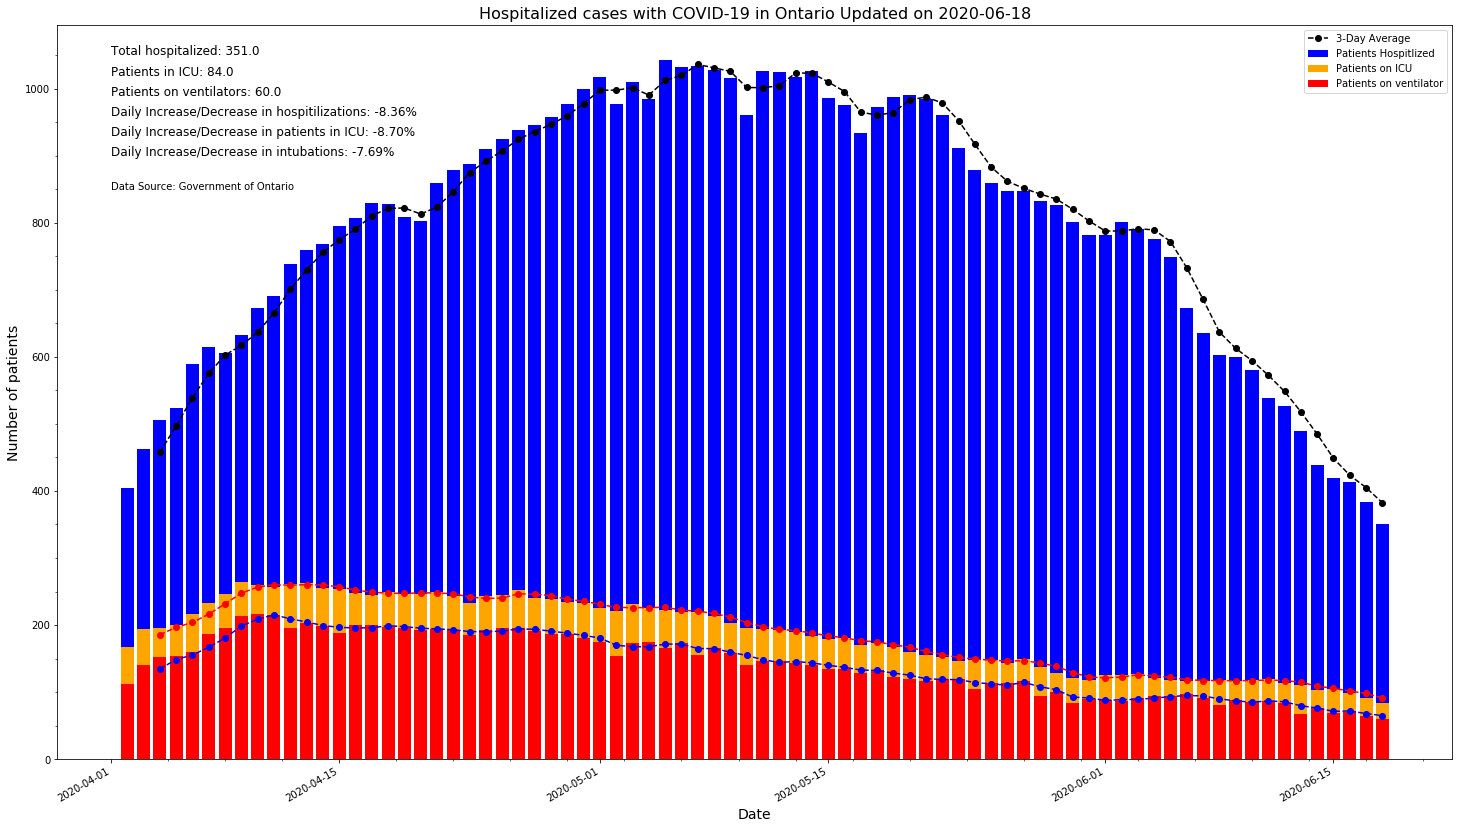

In [14]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], label='Patients Hospitlized', color='blue')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Hosp_MA3'], 'ko--', label='3-Day Average')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU with COVID-19'], label='Patients on ICU', color='orange')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['ICU_MA3'], 'ro--')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], label='Patients on ventilator', color='red')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Ventilator_MA3'], 'bo--')
ax.text(x=dt.datetime(2020,4,1), y=1050,s='Total hospitalized: '+str(Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,4,1), y=1020,s='Patients in ICU: '+str(Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,4,1), y=990,s='Patients on ventilators: '+str(Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,4,1), y=960,s='Daily Increase/Decrease in hospitilizations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]-Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2])/Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2]*100))+'%', fontsize=12) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,4,1), y=930,s='Daily Increase/Decrease in patients in ICU: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,4,1), y=900,s='Daily Increase/Decrease in intubations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,4,1), y=850,s='Data Source: Government of Ontario')
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)
plt.title('Hospitalized cases with COVID-19 in Ontario Updated on '+ str(dt.date.today()) , fontsize=16)
plt.minorticks_on()
plt.show()

## Testing data is an important metric for any Governmen to detect infection propagation trends. As done previously, note the various metrics generated in the plot

In [15]:
ON_testing_goal_met=0
for i in range(len(Ontario_confirmed_df)):
    if Ontario_confirmed_df['Total tests completed in the last day'][i]>16000:
        ON_testing_goal_met+=1

In [16]:
ON_testing_goal_met

28

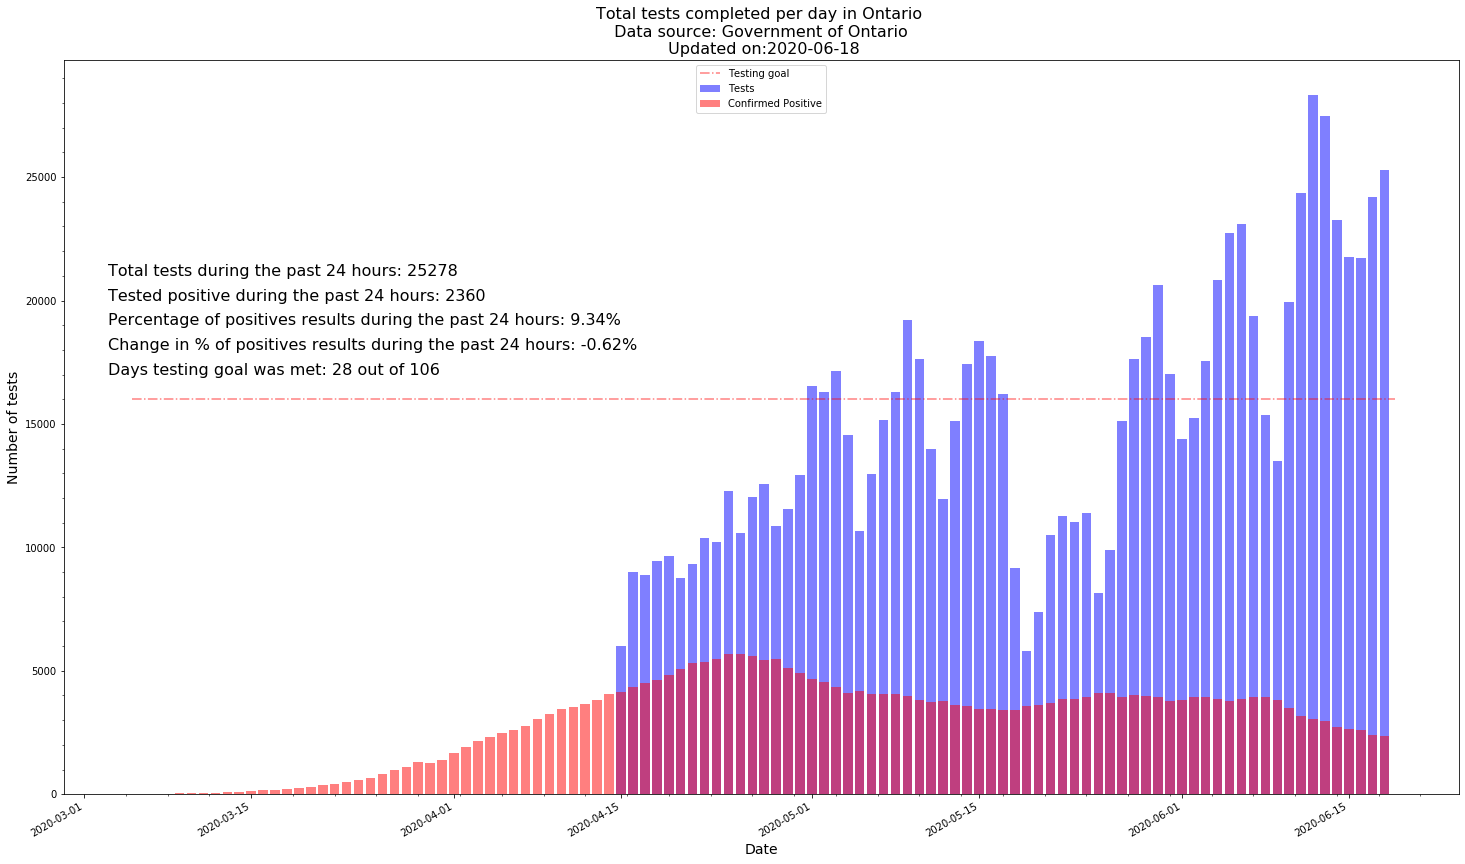

In [17]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Total tests completed in the last day'], label='Tests', color='blue', alpha=0.5)
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Positive'], label='Confirmed Positive', color='red', alpha=0.5)
ax.text(x=dt.datetime(2020,3,3), y=21000,s='Total tests during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Total tests completed in the last day'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=20000,s='Tested positive during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=19000,s='Percentage of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=18000,s='Change in % of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1])-(Ontario_confirmed_df['Confirmed Positive'][-2]/Ontario_confirmed_df['Total tests completed in the last day'][-2]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=17000,s='Days testing goal was met: '+str(ON_testing_goal_met)+' out of '+str(len(Ontario_confirmed_df)), fontsize=16)
#ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Negative'], label='Confirmed Negative', color='red', alpha=0.3)
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of tests', fontsize=14)
plt.title('Total tests completed per day in Ontario \n Data source: Government of Ontario \n Updated on:'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
plt.hlines(16000, dt.datetime(2020,3,5), dt.datetime.today(), color='red', label='Testing goal', linestyles='dashdot', alpha=0.5) #Displaying a horizontal dash line across the graph
plt.legend(loc='upper center')

plt.show()

## Plotting cumulative, active, and resolved cases in Ontario

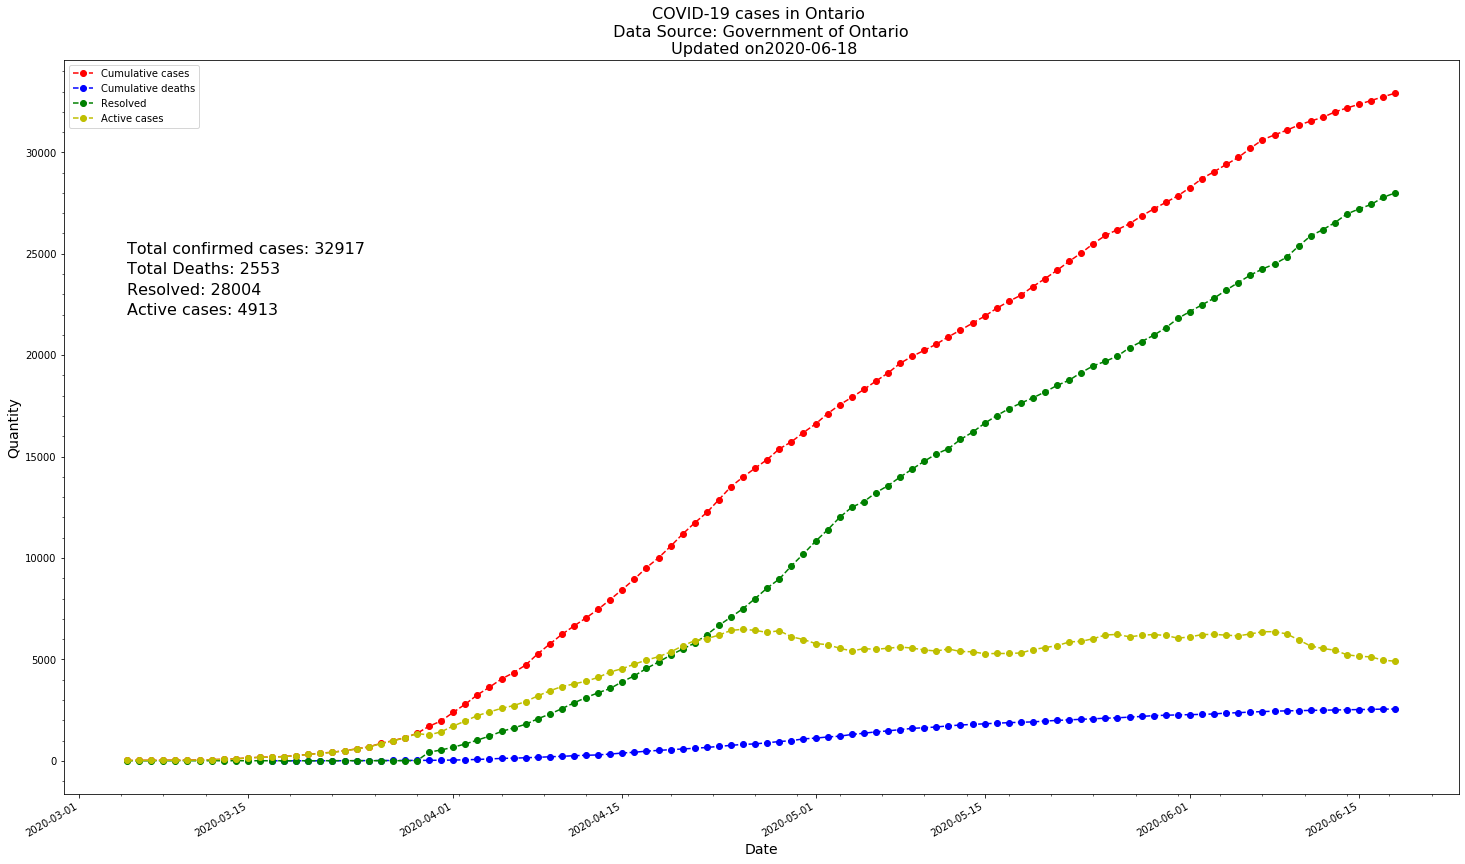

In [18]:
fig, ax=plt.subplots(figsize=(25,15))
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases, 'ro--', label='Cumulative cases')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_deaths, 'bo--', label='Cumulative deaths')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Resolved'],  'go--', label='Resolved')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases-Ontario_confirmed_df['Resolved'], 'yo--', label='Active cases')
ax.text(x=dt.datetime(2020,3,5), y=25000,s='Total confirmed cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=24000,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=23000,s='Resolved: '+str('{0:.0f}'.format(Ontario_confirmed_df.Resolved[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=22000,s='Active cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1]-Ontario_confirmed_df['Resolved'][-1])), fontsize=16)
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('COVID-19 cases in Ontario \n Data Source: Government of Ontario \n Updated on'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
#plt.grid(which='major')
plt.show()

## We plot the daily new cases of infections and deaths in New York State using matplotlib. In order to metigate day-to-day fluctuations, the blue line tracks a 7-days rolling average of new infections to show a more general trend of the 'curve' which appears to be on the downward trend since April 15. A few texts combined with variables are also plotted on the chart to reflect important changes such as change in new infections and deaths. 
## Note the surge in death cases on May 6 - This is caused by the NYT starting to report probable COVID-19 related deaths and not only the ones confirmed by testing.

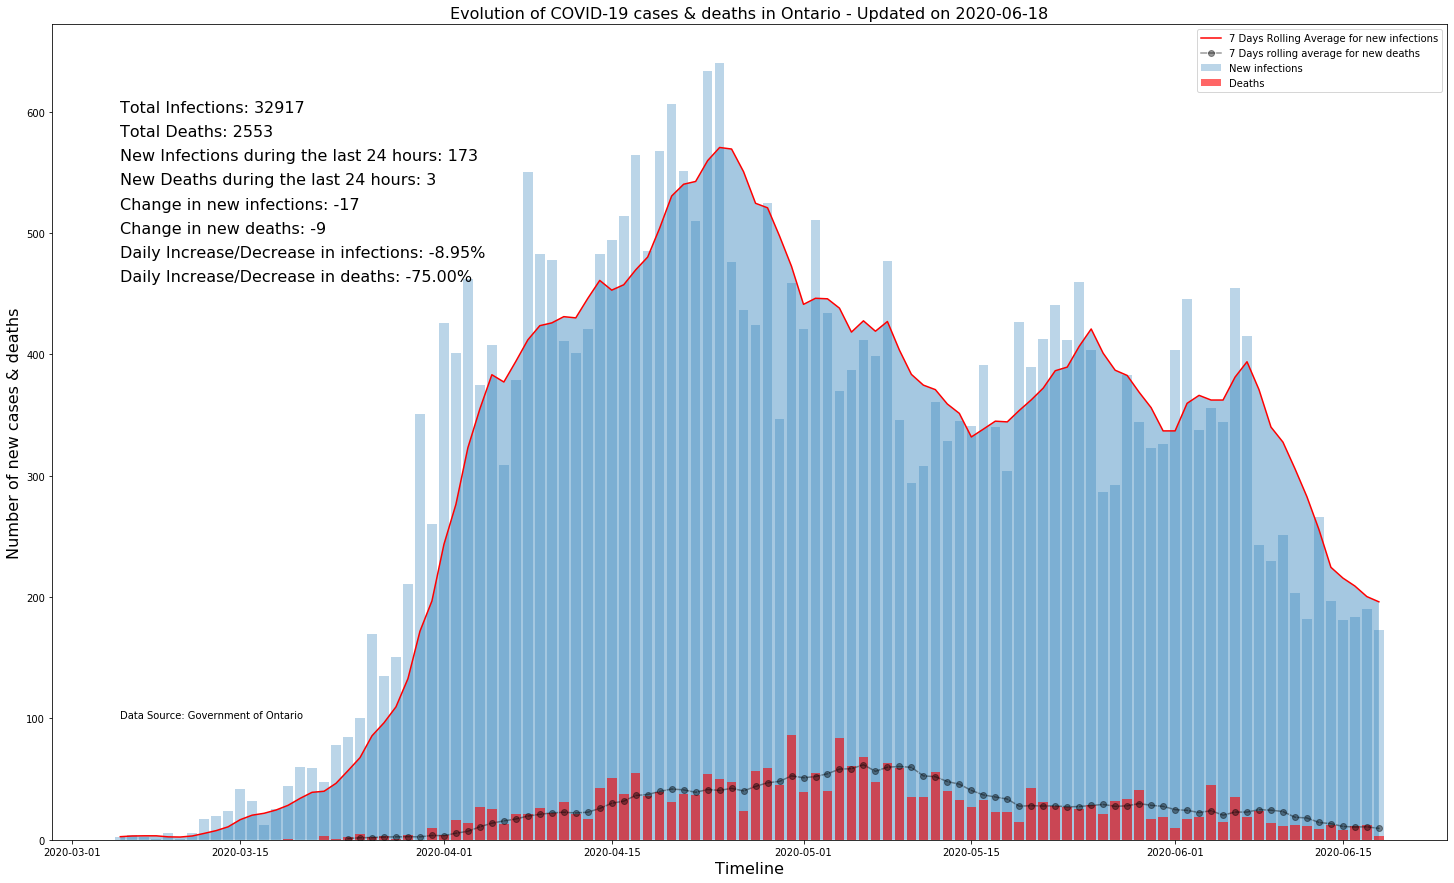

In [19]:
#pd.date_range(start='2020-01-22', periods=len(Ontario_confirmed_df), freq='D')
fig, ax=plt.subplots(figsize=(25,15))
ax.xaxis_date()
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases, alpha=0.3, label='New infections')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, labels=[], alpha=0.4 )
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, color='red', label= '7 Days Rolling Average for new infections')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths_MA7, 'ko--', dash_capstyle='projecting', alpha=0.4, label='7 Days rolling average for new deaths' )
ax.text(x=dt.datetime(2020,3,5), y=600,s='Total Infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=580,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=560,s='New Infections during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=540,s='New Deaths during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=520,s='Change in new infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=500,s='Change in new deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=480,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])/Ontario_confirmed_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,3,5), y=460,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])/Ontario_confirmed_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=100,s='Data Source: Government of Ontario')
#fig.autofmt_xdate()
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
#ax.fmt_xdata = mdates.date_ticker_factory()
#plt.tight_layout()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in Ontario - Updated on '+str(dt.date.today()), fontsize=16)
plt.savefig('COVID19ON.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## The below chart is generated with Plotly Express library, with a main advantage that it's an interactive chart and easy to generate mainly inteded for tidy date! Just hover the mouse over the chart and you will be able to read the details of each day & many other functions!

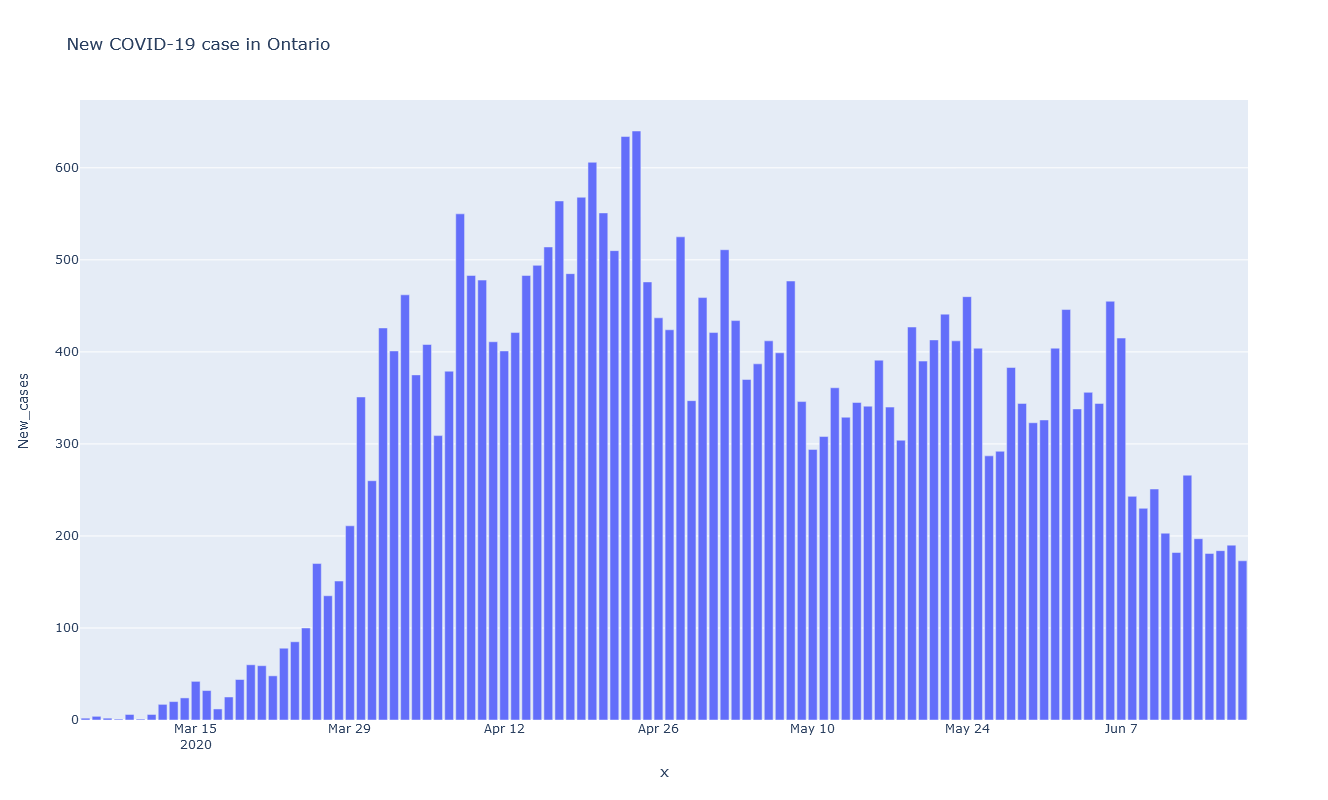

In [20]:
fig = px.bar(data_frame=Ontario_confirmed_df, x=Ontario_confirmed_df.index, y='New_cases', title='New COVID-19 case in Ontario', width=1400, height= 800)
fig.show()

## This chart is done using the standard Plotly library using the 'go.Figure' method. This was allows us to use multiple layers as illustrated-below

In [21]:
fig=go.Figure()
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases, name='Infections'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_deaths, name='Deaths'))
fig.add_trace(go.Scatter(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases_MA7, name='7-Days rolling average'))
fig.update_layout(title='Daily new infections and deaths in Ontario', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Covid-Ontario')


'https://plotly.com/~ralhusban/4/'

In [22]:
fig=go.Figure(skip_invalid=True)
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], name='Hospitalizations'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU with COVID-19'], name='Patients in ICU'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], name='Intubated'))
fig.update_layout(title='Onatario hospitalizations with COVID-19', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Ontario_Covid19')


'https://plotly.com/~ralhusban/22/'

## A word of caution on both models attempted below: The Data that trained the model is very limited to produce a reliable model. Also a significant downside is that our only variable is the number of new infections. More advances and successful models take into account many variables such as how a population adheres to social distancing, the R^0 of the contagion, etc.

## Prophet (Built by Facebook). This library required your dataframe to have a date column called 'ds' and a 'y' column containing the numeric data you want to fit the model with. Hence we do some manipulations with our dataframe to make sure it fits the requirement.

In [23]:
test_df=Ontario_confirmed_df[['New_cases']] # Since the dataframe's index is the date, we only need the new cases column

In [24]:
test_df.rename(columns={'New_cases':'y'}, inplace=True)
test_df['ds']=test_df.index # Copied the index to the 'ds' date column as required by Prophet

C:\Users\amg_m\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## We initialize the Prophet forecasting procedure below. Notice that there are two growth options, logistic, and linear. The logistic growth did not fit the needs of an epidimiological model hence we opted for the default linear option while enabling the MCMC parameter (Markov Chain Monte Carlo) which allows us to include seasonal uncertanties and a full Baysian sampling.

In [25]:
m=Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, mcmc_samples=300) #Initiated a Prophet instance, and disabling all three parameters of seasonality

In [26]:
m.fit(test_df) # Model is fit with the dataframe e.g. trained

In [27]:
future=m.make_future_dataframe(periods=90) # A very useful function which builds a new dataframe with future dates to integrate the forcasted data. Here we chose to go 30 days into the future.

In [28]:
forecast = m.predict(future) # We initiated forecasting and passed the future dataframe as a parameter
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds        yhat  yhat_lower  yhat_upper
191 2020-09-12 -175.156095 -570.473849  189.796331
192 2020-09-13 -180.014801 -573.655791  199.494061
193 2020-09-14 -184.873508 -589.437725  202.979933
194 2020-09-15 -189.732215 -579.129278  215.560813
195 2020-09-16 -194.590922 -606.167093  197.257306

In [29]:
forecast.head(-20)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2020-03-05 -54.635839 -155.641395   39.675228   -82.030355   -24.094902   
1   2020-03-06 -41.830825 -142.202122   61.480520   -68.349136   -12.318960   
2   2020-03-07 -29.025811 -134.765880   78.915499   -54.739563    -0.277344   
3   2020-03-08 -16.220796 -116.563598   86.707762   -41.237985    11.535907   
4   2020-03-09  -3.403659 -109.299883   95.021538   -27.766817    22.113474   
..         ...        ...         ...         ...          ...          ...   
171 2020-08-23 -77.981956 -354.666621  191.762840  -321.804069   175.070302   
172 2020-08-24 -82.840663 -353.104571  182.609358  -335.166975   174.514916   
173 2020-08-25 -87.699370 -361.503013  185.166090  -346.593937   174.489084   
174 2020-08-26 -92.558077 -365.191393  189.487975  -359.592084   174.749901   
175 2020-08-27 -97.416784 -380.256836  192.281682  -369.281337   174.890030   

     additive_terms  additive_terms_lower  additive_terms_upper  \
0               0.0                   0.0                   0.0   
1               0.0                   0.0                   0.0   
2               0.0                   0.0                   0.0   
3               0.0                   0.0                   0.0   
4               0.0                   0.0                   0.0   
..              ...                   ...                   ...   
171             0.0                   0.0                   0.0   
172             0.0                   0.0                   0.0   
173             0.0                   0.0                   0.0   
174             0.0                   0.0                   0.0   
175             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
171                   0.0                         0.0   
172                   0.0                         0.0   
173                   0.0                         0.0   
174                   0.0                         0.0   
175                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
0                           0.0 -54.635839  
1                           0.0 -41.830825  
2                           0.0 -29.025811  
3                           0.0 -16.220796  
4                           0.0  -3.403659  
..                          ...        ...  
171                         0.0 -77.981956  
172                         0.0 -82.840663  
173                         0.0 -87.699370  
174                         0.0 -92.558077  
175                         0.0 -97.416784  

[176 rows x 13 columns]

## Below plot illustrates the actual data in purple dotted line while the solid lines represented the upper, lower, and mid y_hat (forecast) ranges generated by the Prophet.
## The sharp increase in cases and deaths on May 6th destabilized the model. This is caused by the NYT starting to report probable COVID-19 cases and deaths and not only the ones confirmed by testing.

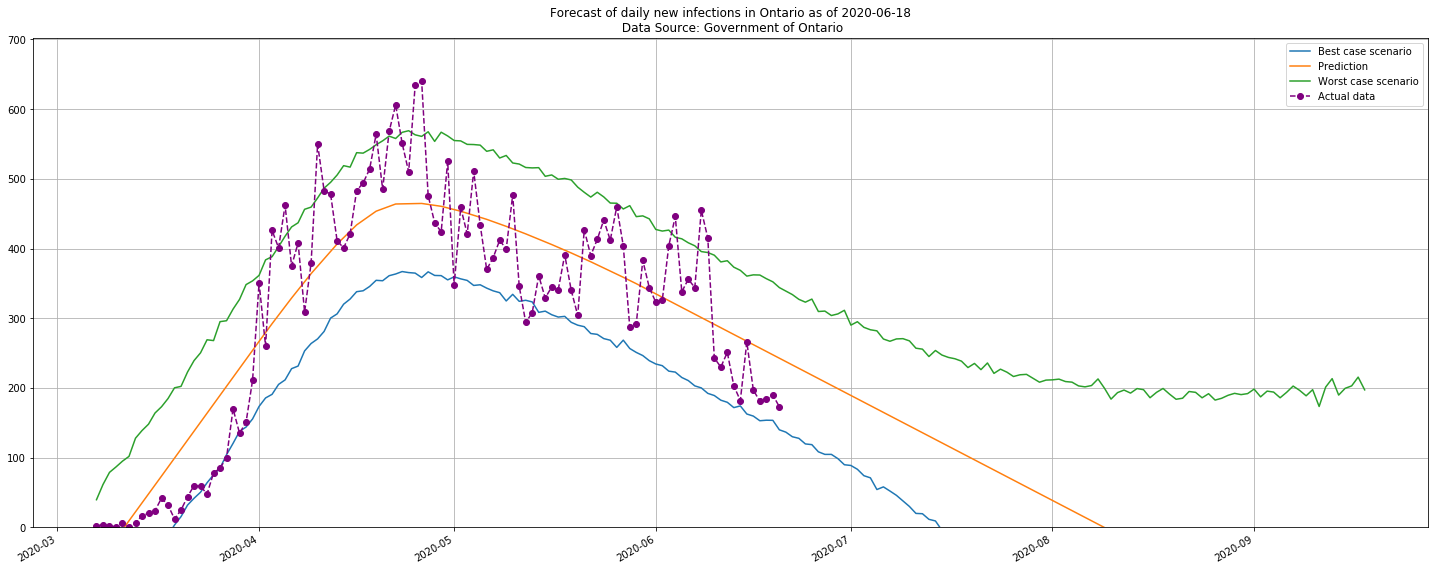

In [30]:
fig, ax=plt.subplots(figsize=(25,10))
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_lower, label='Best case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'),forecast.yhat, label='Prediction')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_upper, label='Worst case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(test_df), freq='D'), test_df.y,  'o--', label='Actual data', color='purple')
plt.title('Forecast of daily new infections in Ontario as of '+ str(dt.date.today()) + '\n Data Source: Government of Ontario')
plt.legend()
plt.grid()
#plt.hlines(y=0, xmin=0, xmax=len(future), color='red')
plt.ylim(bottom=0)
fig.autofmt_xdate()
plt.show()

## The below plot is built-in in the Prophet, it illustrates the same data

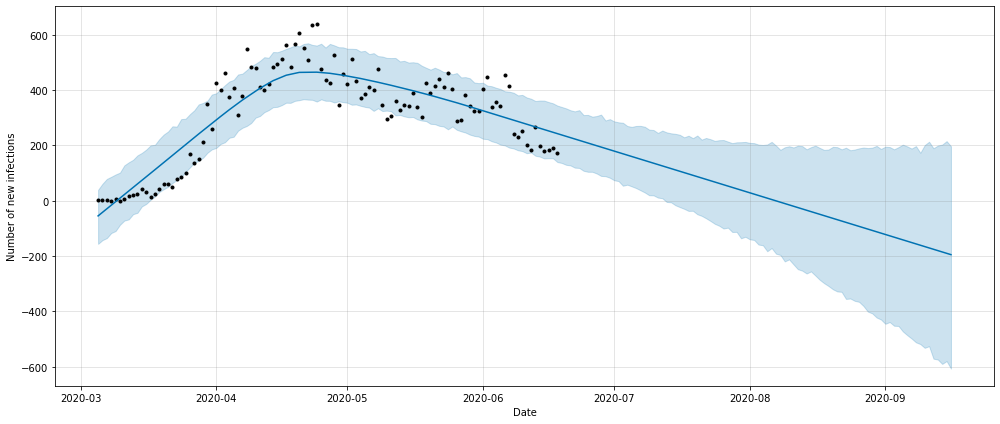

In [31]:
fig1=m.plot(forecast.iloc[:1500], figsize=(14,6), xlabel='Date', ylabel='Number of new infections')

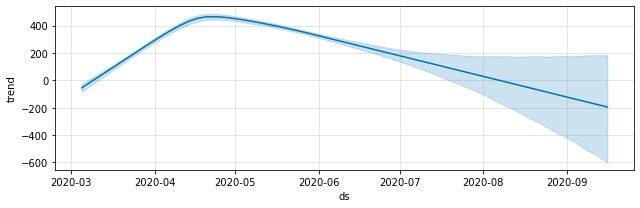

In [32]:
fig=m.plot_components(forecast)

In [33]:
Ontario_clinic_data.sort_values(by=['Accurate_Episode_Date'], ascending=True, inplace=True)
Ontario_clinic_data['Accurate_Episode_Date']=pd.to_datetime(Ontario_clinic_data.Accurate_Episode_Date)

In [34]:
Ontario_clinic_data

Row_ID Accurate_Episode_Date Case_Reported_Date Test_Reported_Date  \
20298   20299            2020-01-01         2020-05-17         2020-05-17   
13859   13860            2020-01-01         2020-04-24         2020-04-24   
24640   24641            2020-01-10         2020-06-10                NaN   
1           2            2020-01-21         2020-01-23         2020-01-27   
0           1            2020-01-22         2020-01-23         2020-01-27   
...       ...                   ...                ...                ...   
25354   25355            2020-06-17         2020-06-17         2020-06-17   
25355   25356            2020-06-17         2020-06-17         2020-06-17   
25351   25352            2020-06-17         2020-06-17         2020-06-17   
25350   25351            2020-06-17         2020-06-17         2020-06-17   
30782   30783                   NaT         2020-06-09         2020-06-09   

      Specimen_Date Age_Group Client_Gender Case_AcquisitionInfo  \
20298    2020-05-15       50s          MALE                   CC   
13859    2020-04-23       80s          MALE          No Epi-link   
24640           NaN       50s          MALE                   OB   
1        2020-01-23       50s          MALE               Travel   
0        2020-01-25       50s        FEMALE               Travel   
...             ...       ...           ...                  ...   
25354    2020-06-16       30s        FEMALE      No Info-Missing   
25355    2020-06-16       40s        FEMALE      No Info-Missing   
25351    2020-06-16       60s          MALE          No Epi-link   
25350    2020-06-15       70s        FEMALE      No Info-Missing   
30782    2020-06-08       <20        FEMALE                   OB   

           Outcome1 Outbreak_Related                      Reporting_PHU  \
20298      Resolved              NaN  Region of Waterloo, Public Health   
13859      Resolved              NaN      Haldimand-Norfolk Health Unit   
24640      Resolved              Yes      Haldimand-Norfolk Health Unit   
1          Resolved              NaN              Toronto Public Health   
0          Resolved              NaN              Toronto Public Health   
...             ...              ...                                ...   
25354  Not Resolved              NaN                 Peel Public Health   
25355  Not Resolved              NaN                 Peel Public Health   
25351  Not Resolved              NaN        Eastern Ontario Health Unit   
25350  Not Resolved              NaN  Region of Waterloo, Public Health   
30782      Resolved              Yes              Toronto Public Health   

                Reporting_PHU_Address Reporting_PHU_City  \
20298          99 Regina Street South           Waterloo   
13859             12 Gilbertson Drive             Simcoe   
24640             12 Gilbertson Drive             Simcoe   
1      277 Victoria Street, 5th Floor            Toronto   
0      277 Victoria Street, 5th Floor            Toronto   
...                               ...                ...   
25354          7120 Hurontario Street        Mississauga   
25355          7120 Hurontario Street        Mississauga   
25351                1000 Pitt Street           Cornwall   
25350          99 Regina Street South           Waterloo   
30782  277 Victoria Street, 5th Floor            Toronto   

      Reporting_PHU_Postal_Code  \
20298                   N2J 4V3   
13859                   N3Y 4N5   
24640                   N3Y 4N5   
1                       M5B 1W2   
0                       M5B 1W2   
...                         ...   
25354                   L5W 1N4   
25355                   L5W 1N4   
25351                   K6J 5T1   
25350                   N2J 4V3   
30782                   M5B 1W2   

                                   Reporting_PHU_Website  \
20298                            www.regionofwaterloo.ca   
13859                                       www.hnhu.org   
24640                                     

In [35]:
#Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU','Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1'], ).agg(['count'])['Reporting_PHU_City'].sort_values(by=['Reporting_PHU'],ascending=True)
Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Outcome1'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_case_source=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_age_group=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Age_Group'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})

In [36]:

unresolved_df=Grouped_Ontario_Clinic_Data[Grouped_Ontario_Clinic_Data.Outcome1=='Not Resolved'].sort_values(by='Row_ID', ascending=False)

In [37]:
unresolved_df.rename(columns={'Outcome1':'Status','Row_ID':'Qty'}, inplace=True)

In [49]:
unresolved_df.head(15)

Reporting_PHU_City        Status  Qty  Reporting_PHU_Latitude  \
81            Toronto  Not Resolved  904               43.656591   
30        Mississauga  Not Resolved  539               43.647471   
90            Windsor  Not Resolved  235               42.308796   
34          Newmarket  Not Resolved  157               44.048023   
87             Whitby  Not Resolved   67               43.898605   
84           Waterloo  Not Resolved   63               43.462876   
43             Ottawa  Not Resolved   58               45.345665   
21           Hamilton  Not Resolved   57               43.257631   
40           Oakville  Not Resolved   53               43.413997   
18             Guelph  Not Resolved   46               43.524881   
1              Barrie  Not Resolved   39               44.410713   
27             London  Not Resolved   38               42.981468   
62             Simcoe  Not Resolved   20               42.847825   
15           Cornwall  Not Resolved   15               45.029152   
73            Thorold  Not Resolved   14               43.116537   

    Reporting_PHU_Longitude  
81               -79.379358  
30               -79.708893  
90               -83.033670  
34               -79.480239  
87               -78.940341  
84               -80.520913  
43               -75.763912  
21               -79.871341  
40               -79.744796  
18               -80.233743  
1                -79.686306  
27               -81.254016  
62               -80.303815  
15               -74.736298  
73               -79.241220

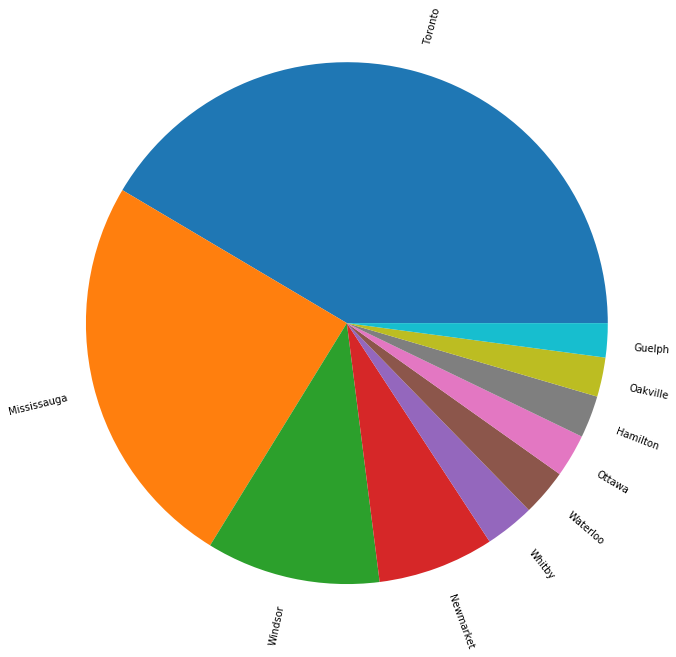

In [54]:
plt.pie(unresolved_df.Qty[unresolved_df.Qty>40], labels=unresolved_df.Reporting_PHU_City[unresolved_df.Qty>40], radius=3, rotatelabels=True)
plt.show()

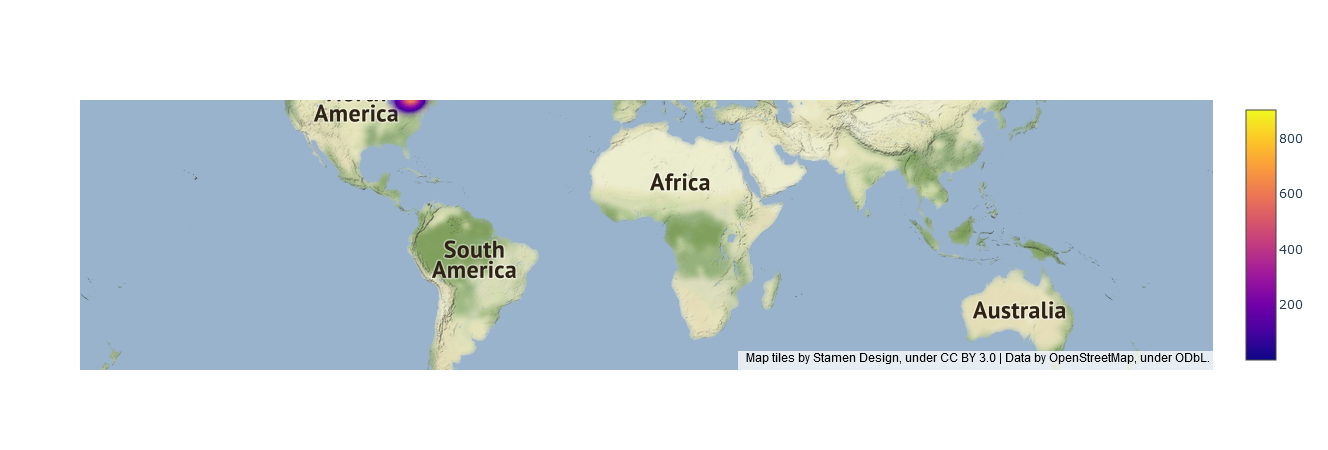

In [40]:
fig = go.Figure(go.Densitymapbox(lat=unresolved_df.Reporting_PHU_Latitude, lon=unresolved_df.Reporting_PHU_Longitude, z=unresolved_df.Qty,
                                 radius=20))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=3)
#fig.update_layout(margin={"r":10,"t":0,"l":0,"b":1})
fig.show()

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



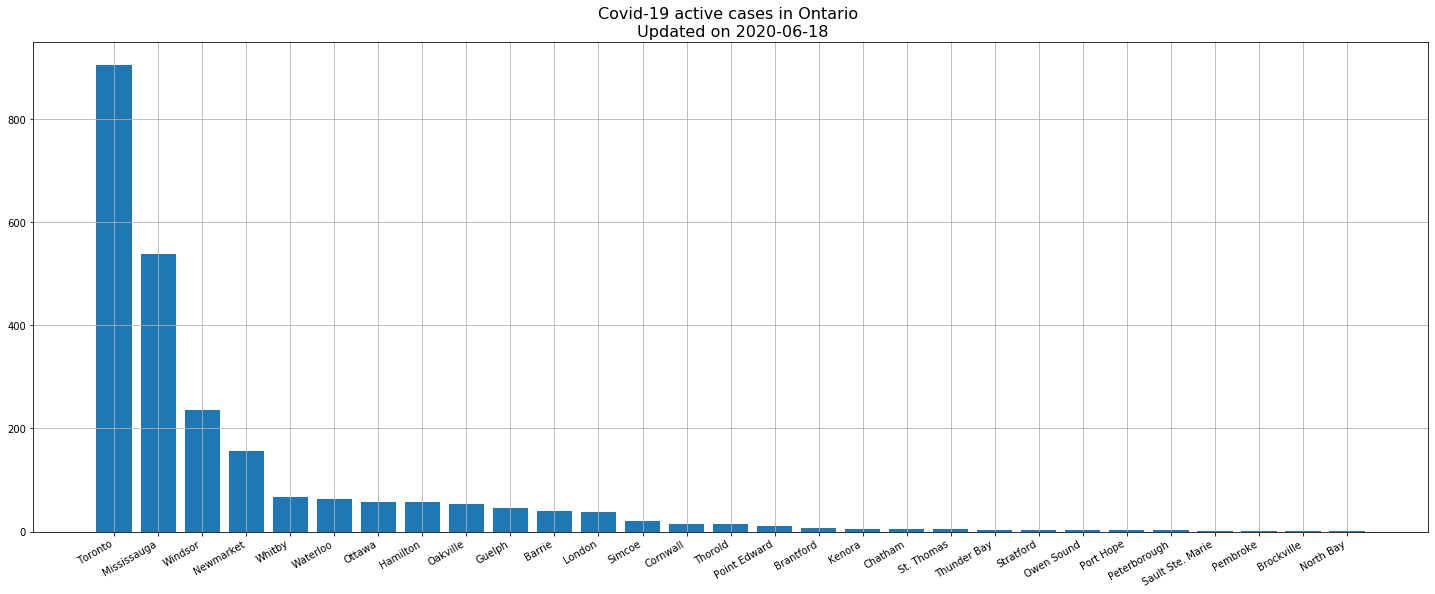

In [41]:
fig, ax=plt.subplots(figsize=(25,10))
plt.bar(unresolved_df.Reporting_PHU_City, unresolved_df.Qty)
fig.autofmt_xdate()
plt.grid()
plt.title('Covid-19 active cases in Ontario \n Updated on '+str(dt.date.today()), fontsize=16)
fig.show()



In [42]:
active_by_age_group=Grouped_Ontario_Clinic_Data_age_group.sort_values(by='Row_ID', ascending=False)

In [43]:
active_age_group_Toronto=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Toronto']
active_age_group_Missisauga=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Missisauga']
active_age_group_Ottawa=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Ottawa']
active_age_group_Oakville=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Oakville']
active_age_group_Hamilton=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Hamilton']

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



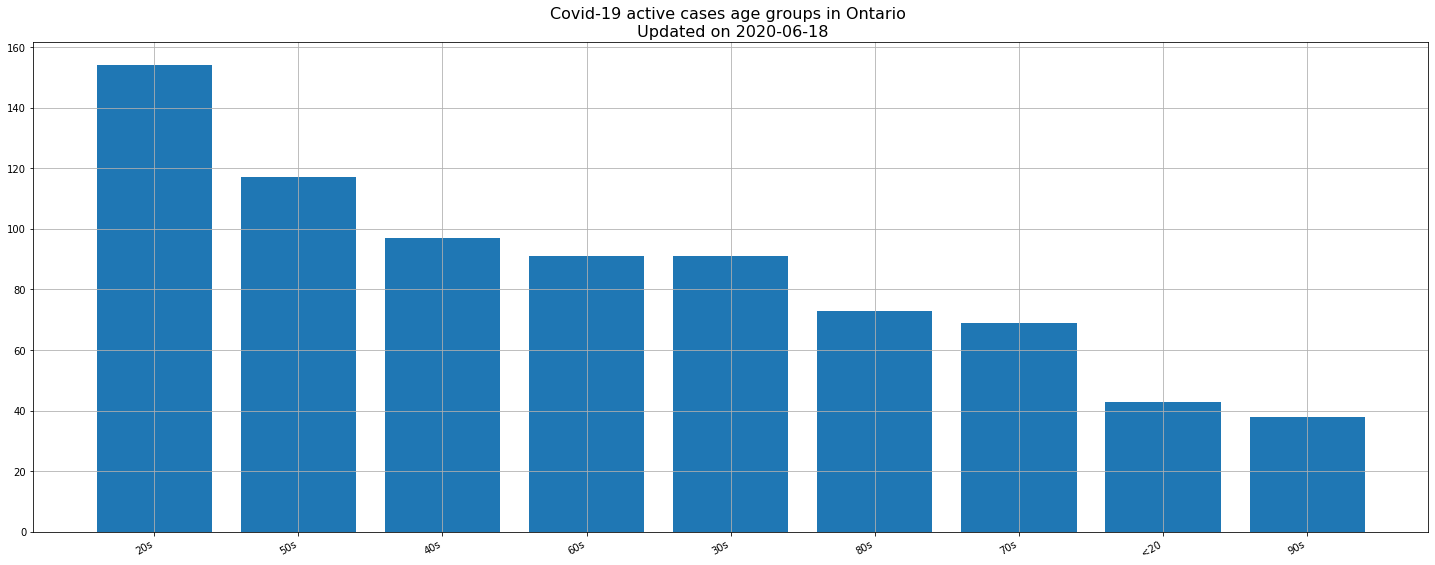

In [44]:
fig, ax=plt.subplots(figsize=(25,10))
plt.bar(active_age_group_Hamilton.Age_Group, active_age_group_Hamilton.Row_ID)
fig.autofmt_xdate()
plt.grid()
plt.title('Covid-19 active cases age groups in Ontario \n Updated on '+str(dt.date.today()), fontsize=16)
fig.show()


In [45]:
active_by_age_group

Reporting_PHU_City Age_Group  Row_ID  Reporting_PHU_Latitude  \
262            Toronto       50s    2016               43.656591   
261            Toronto       40s    1796               43.656591   
260            Toronto       30s    1734               43.656591   
259            Toronto       20s    1642               43.656591   
265            Toronto       80s    1389               43.656591   
..                 ...       ...     ...                     ...   
197   Sault Ste. Marie       <20       1               46.532373   
76              Kenora       90s       1               49.769615   
224          Stratford       <20       1               43.368662   
250            Timmins       20s       1               48.472510   
214         St. Thomas       90s       1               42.777804   

     Reporting_PHU_Longitude  
262               -79.379358  
261               -79.379358  
260               -79.379358  
259               -79.379358  
265               -79.379358  
..                       ...  
197               -84.314836  
76                -94.488254  
224               -81.001913  
250               -81.328750  
214               -81.151156  

[296 rows x 5 columns]

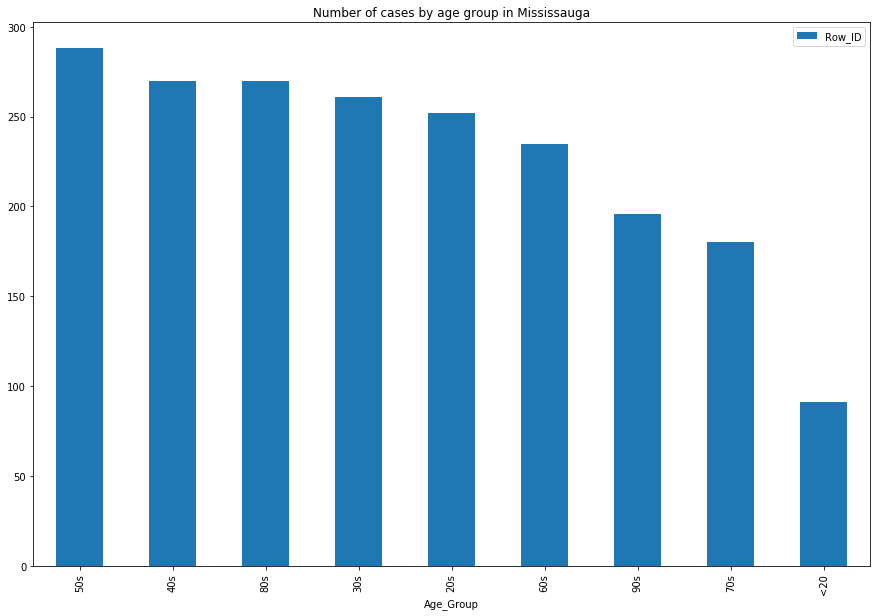

In [46]:
active_by_age_group[['Reporting_PHU_City','Age_Group','Row_ID']].groupby(['Reporting_PHU_City']).get_group('Ottawa').plot(kind='bar', x='Age_Group', figsize=(15,10), title='Number of cases by age group in Mississauga')
#Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
